## 2️⃣ Tworzenie cech (Feature Engineering)

W tej części rozpoczynam proces **tworzenia nowych zmiennych pochodnych (features)**, które będą stanowić podstawę do dalszego modelowania.  
Celem jest rozszerzenie danych wejściowych o informacje, które mogą lepiej opisywać przebieg i charakter meczu.

Wszystkie transformacje są wykonywane **po sortowaniu danych chronologicznie**, aby uniknąć zjawiska *data leakage* — tzn. wykorzystywania w obliczeniach informacji z przyszłych meczów.

---



## Importy i konfiguracja

In [82]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


# (opcjonalnie) do estetycznych ostrzeżeń
import warnings
warnings.filterwarnings("ignore")

# (opcjonalnie) biblioteka do FE w stylu "pipeline"
# pip install feature-engine
try:
    from feature_engine.timeseries.forecasting import WindowFeatures, LagFeatures
    FE_AVAILABLE = True
except Exception:
    FE_AVAILABLE = False

DATA_DIR = Path("../data/processed")
IN_PATH = DATA_DIR / "epl_2014_2019_clean.csv"
OUT_PATH = DATA_DIR / "epl_features.csv"

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)


## Wczytanie czystych danych i sanity checks (bez tworzenia nowych cech)

In [83]:
df = pd.read_csv(IN_PATH, parse_dates=["Date"])
df = df.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True)

print(df.shape)
df.head(3)


(3420, 34)


,Div,Date,HomeTeam,AwayTeam,Referee,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,PSH,PSD,PSA,BbMxH,BbMxD,BbMxA,BbAvH,BbAvD,BbAvA,Bb1X2,Season
0,E0,2014-08-16,Arsenal,Crystal Palace,J Moss,2.0,1.0,H,14.0,4.0,6.0,2.0,13.0,19.0,9.0,3.0,2.0,2.0,0.0,1.0,1.25,6.5,15.0,1.26,6.45,14.01,1.30,6.70,16.00,1.25,5.96,12.43,50.0,2014/2015
1,E0,2014-08-16,Leicester,Everton,M Jones,2.0,2.0,D,11.0,13.0,3.0,3.0,16.0,10.0,3.0,6.0,1.0,1.0,0.0,0.0,3.20,3.4,2.4,3.14,3.38,2.46,3.30,3.45,2.42,3.06,3.32,2.36,50.0,2014/2015
2,E0,2014-08-16,Manchester United,Swansea,M Dean,1.0,2.0,A,14.0,5.0,5.0,4.0,14.0,20.0,4.0,0.0,2.0,4.0,0.0,0.0,1.36,5.0,11.0,1.37,5.10,10.60,1.38,5.50,11.03,1.34,4.96,9.32,50.0,2014/2015



### 2A. Statystyki meczu – proste pochodne i różnice

Pierwszym krokiem jest utworzenie prostych cech różnicowych pomiędzy drużynami w danym meczu.  
Zmienne te odzwierciedlają bezpośrednie różnice w liczbie strzałów, fauli, kartek czy rzutów rożnych, a także wynikowe statystyki spotkania (różnica bramek, łączna liczba goli).

Choć nie będą one użyte bezpośrednio do predykcji *przedmeczowej*, stanowią cenną część analizy opisowej oraz mogą posłużyć jako cechy pomocnicze w modelach typu *ex post* (np. do analizy przebiegu meczu lub walidacji jakości predykcji).

In [84]:
# Różnice ofensywne/defensywne w tym meczu
df["ShotsDiff"] = df["HS"] - df["AS"]
df["ShotsOnTargetDiff"] = df["HST"] - df["AST"]
df["CornersDiff"] = df["HC"] - df["AC"]
df["FoulsDiff"] = df["HF"] - df["AF"]
df["CardsDiff"] = (df["HY"] + df["HR"]) - (df["AY"] + df["AR"])

# Wynikowe (przydadzą się też do kontroli jakości)
df["GoalDiff"] = df["FTHG"] - df["FTAG"]
df["TotalGoals"] = df["FTHG"] + df["FTAG"]


In [85]:
df[[
    "Date", "HomeTeam", "AwayTeam",
    "HS", "AS", "ShotsDiff",
    "HST", "AST", "ShotsOnTargetDiff",
    "HC", "AC", "CornersDiff",
    "HF", "AF", "FoulsDiff",
    "HY", "HR", "AY", "AR", "CardsDiff",
    "FTHG", "FTAG", "GoalDiff", "TotalGoals"
]].head(10)


,Date,HomeTeam,AwayTeam,HS,AS,ShotsDiff,HST,AST,ShotsOnTargetDiff,HC,AC,CornersDiff,HF,AF,FoulsDiff,HY,HR,AY,AR,CardsDiff,FTHG,FTAG,GoalDiff,TotalGoals
0,2014-08-16,Arsenal,Crystal Palace,14.0,4.0,10.0,6.0,2.0,4.0,9.0,3.0,6.0,13.0,19.0,-6.0,2.0,0.0,2.0,1.0,-1.0,2.0,1.0,1.0,3.0
1,2014-08-16,Leicester,Everton,11.0,13.0,-2.0,3.0,3.0,0.0,3.0,6.0,-3.0,16.0,10.0,6.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,4.0
2,2014-08-16,Manchester United,Swansea,14.0,5.0,9.0,5.0,4.0,1.0,4.0,0.0,4.0,14.0,20.0,-6.0,2.0,0.0,4.0,0.0,-2.0,1.0,2.0,-1.0,3.0
3,2014-08-16,QPR,Hull,19.0,11.0,8.0,6.0,4.0,2.0,8.0,9.0,-1.0,10.0,10.0,0.0,1.0,0.0,2.0,0.0,-1.0,0.0,1.0,-1.0,1.0
4,2014-08-16,Stoke,Aston Villa,12.0,7.0,5.0,2.0,2.0,0.0,2.0,8.0,-6.0,14.0,9.0,5.0,0.0,0.0,3.0,0.0,-3.0,0.0,1.0,-1.0,1.0
5,2014-08-16,West Brom,Sunderland,10.0,7.0,3.0,5.0,2.0,3.0,6.0,3.0,3.0,18.0,9.0,9.0,3.0,0.0,1.0,0.0,2.0,2.0,2.0,0.0,4.0
6,2014-08-16,West Ham,Tottenham,18.0,10.0,8.0,4.0,4.0,0.0,8.0,5.0,3.0,12.0,10.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,-1.0,1.0
7,2014-08-17,Liverpool,Southampton,12.0,12.0,0.0,5.0,6.0,-1.0,2.0,6.0,-4.0,8.0,11.0,-3.0,1.0,0.0,2.0,0.0,-1.0,2.0,1.0,1.0,3.0
8,2014-08-17,Newcastle,Manchester City,12.0,13.0,-1.0,0.0,5.0,-5.0,3.0,3.0,0.0,8.0,11.0,-3.0,1.0,0.0,5.0,0.0,-4.0,0.0,2.0,-2.0,2.0
9,2014-08-18,Burnley,Chelsea,9.0,11.0,-2.0,2.0,3.0,-1.0,4.0,3.0,1.0,6.0,7.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,-2.0,4.0


## 3) B. Kursy bukmacherskie – przewidywania rynku

Cel: wyciągnąć z kursów „oczekiwania rynku” i ich niepewność.


## cechy rynkowe (market-based features)

In [86]:
# Implikowane prawdopodobieństwa z Bet365 (znormalizowane do 1, uwzględniają marżę)
inv_sum_b365 = (1/df["B365H"]) + (1/df["B365D"]) + (1/df["B365A"])
df["Prob_H_b365"] = (1/df["B365H"]) / inv_sum_b365
df["Prob_D_b365"] = (1/df["B365D"]) / inv_sum_b365
df["Prob_A_b365"] = (1/df["B365A"]) / inv_sum_b365

# Marża rynku (im wyższa, tym mniej "uczciwe" kursy; może korelować z niepewnością)
df["Margin_B365"] = inv_sum_b365 - 1

# Różnice kursów (siła faworyta)
df["OddsDiff_B365"] = df["B365H"] - df["B365A"]

# To samo dla Pinnacle (closing odds) – często jakościowy sygnał
mask_ps = df[["PSH","PSD","PSA"]].notna().all(axis=1)
inv_sum_ps = (1/df["PSH"]) + (1/df["PSD"]) + (1/df["PSA"])
df["Prob_H_ps"] = np.where(mask_ps, (1/df["PSH"]) / inv_sum_ps, np.nan)
df["Prob_D_ps"] = np.where(mask_ps, (1/df["PSD"]) / inv_sum_ps, np.nan)
df["Prob_A_ps"] = np.where(mask_ps, (1/df["PSA"]) / inv_sum_ps, np.nan)
df["Margin_PS"]  = np.where(mask_ps, inv_sum_ps - 1, np.nan)
df["OddsDiff_PS"] = df["PSH"] - df["PSA"]

# Agregacja "marketowa" (BetBrain: max vs average)
df["OddsSpread_H"] = df["BbMxH"] - df["BbAvH"]
df["OddsSpread_D"] = df["BbMxD"] - df["BbAvD"]
df["OddsSpread_A"] = df["BbMxA"] - df["BbAvA"]


Interpretacja:

Prob_* – „jak rynek ocenia szanse” (świetne predyktory),

Margin_* – marża rynku; czasem wyższa przy meczach niszowych/niewygodnych,

OddsDiff_* – siła faworyta,

OddsSpread_* – rozrzut kursów między bukami → „niepewność”.

In [87]:
df[[
    "B365H", "B365D", "B365A",
    "Prob_H_b365", "Prob_D_b365", "Prob_A_b365",
    "Margin_B365", "OddsDiff_B365"
]].head(10)


,B365H,B365D,B365A,Prob_H_b365,Prob_D_b365,Prob_A_b365,Margin_B365,OddsDiff_B365
0,1.25,6.50,15.00,0.7839,0.1508,0.0653,0.0205,-13.75
1,3.20,3.40,2.40,0.3054,0.2874,0.4072,0.0233,0.80
2,1.36,5.00,11.00,0.7165,0.1949,0.0886,0.0262,-9.64
3,2.50,3.30,3.10,0.3900,0.2955,0.3145,0.0256,-0.60
4,1.95,3.50,4.50,0.5024,0.2799,0.2177,0.0208,-2.55
5,2.25,3.40,3.50,0.4339,0.2871,0.2789,0.0243,-1.25
6,3.80,3.60,2.05,0.2558,0.2700,0.4742,0.0287,1.75
7,1.33,5.75,10.00,0.7330,0.1695,0.0975,0.0258,-8.67
8,5.25,4.33,1.67,0.1867,0.2264,0.5869,0.0202,3.58
9,9.00,5.00,1.40,0.1084,0.1950,0.6966,0.0254,7.60


In [88]:
df[["Margin_B365", "Margin_PS"]].describe().T


,count,mean,std,min,25%,50%,75%,max
Margin_B365,3420.0,0.0399,0.0153,0.0169,0.0257,0.0316,0.0539,0.1667
Margin_PS,3420.0,0.0242,0.0058,0.0125,0.0202,0.0219,0.0265,0.0591


# 4) C. Forma drużyny (rolling window features) – część najważniejsza


Cel: policzyć cechy formy do dnia meczu (bez zaglądania w przyszłość). Zrobimy to tak:

Zmienimy dane w perspektywę „jeden wiersz = jeden mecz z perspektywy konkretnej drużyny” (home i away osobno).

Policzmy punkty w danym meczu z perspektywy drużyny: wygrana=3, remis=1, porażka=0.

Dla każdej drużyny posortujemy mecze po dacie i policzymy rolling średnie/sumy z ostatnich n meczów po shift(1) (żeby nie używać bieżącego meczu).

Zmergujemy z powrotem do oryginalnej tabeli jako cechy Home* i Away*.

In [89]:
base_cols = ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]

# widok z perspektywy gospodarzy
home = df[base_cols].copy()
home["Team"] = home["HomeTeam"]
home["Opponent"] = home["AwayTeam"]
home["GF"] = home["FTHG"]
home["GA"] = home["FTAG"]

# widok z perspektywy gości
away = df[base_cols].copy()
away["Team"] = away["AwayTeam"]
away["Opponent"] = away["HomeTeam"]
away["GF"] = away["FTAG"]
away["GA"] = away["FTHG"]

# wynik punktowy dla drużyny w meczu
def points_for_row(gf, ga):
    if gf > ga: return 3
    if gf == ga: return 1
    return 0

for part in (home, away):
    part["Points"] = [points_for_row(gf, ga) for gf, ga in zip(part["GF"], part["GA"])]

tmatches = pd.concat([home[["Date","Team","Opponent","GF","GA","Points"]],
                      away[["Date","Team","Opponent","GF","GA","Points"]]],
                     ignore_index=True)

tmatches = tmatches.sort_values(["Team","Date"]).reset_index(drop=True)


## Etap	            Cel
Tworzy dwa widoki: home i away	Oddzielnie opisuje każdy mecz z punktu widzenia obu drużyn
Dodaje punkty	Oblicza punkty za mecz (3/1/0)
Łączy dane	Tworzy pełną tabelę: każda drużyna = jeden wiersz na mecz
Sortuje	Przygotowuje dane do obliczeń historycznych (rolling, lag, forma)

In [90]:
# Sumowanie punktów dla każdej drużyny
team_points = (
    tmatches.groupby("Team")["Points"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Wyświetlenie tabeli
team_points.columns = ["Drużyna", "Łączna liczba punktów"]
display(team_points)


,Drużyna,Łączna liczba punktów
0,Manchester City,780
1,Liverpool,680
2,Arsenal,657
3,Tottenham,627
4,Chelsea,620
5,Manchester United,619
6,West Ham,461
7,Everton,440
8,Leicester,417
9,Crystal Palace,410


## Rolling features

In [91]:
# okno "ostatnich 5 meczów"
WINDOW = 5

grp = tmatches.groupby("Team", group_keys=False)

tmatches["GF_last5"] = grp["GF"].apply(lambda s: s.shift(1).rolling(WINDOW, min_periods=1).mean()) # Średnia liczba goli strzelonych w ostatnich 5 meczach
tmatches["GA_last5"] = grp["GA"].apply(lambda s: s.shift(1).rolling(WINDOW, min_periods=1).mean()) # Średnia liczba goli straconych w ostatnich 5 meczach 
tmatches["GD_last5"] = grp.apply(lambda g: (g["GF"] - g["GA"]).shift(1).rolling(WINDOW, min_periods=1).mean()).reset_index(level=0, drop=True) # Średnia różnica bramek w ostatnich 5 meczach (np 10 strzeolynch, 8 straconych --> 2)
tmatches["Pts_last5"] = grp["Points"].apply(lambda s: s.shift(1).rolling(WINDOW, min_periods=1).mean()) # Średnia liczba punktów z ostatnich 5 meczów
tmatches["Wins_last5"] = grp["Points"].apply(lambda s: (s.shift(1) == 3).rolling(WINDOW, min_periods=1).sum()) #  Liczba zwycięstw w ostatnich 5 meczach:
tmatches["CleanSheets_last5"] = grp["GA"].apply(lambda s: (s.shift(1) == 0).rolling(WINDOW, min_periods=1).sum())  # Czyste konta w ostatnich 5 meczach 
tmatches["Conceded0plus_last5"] = grp["GA"].apply(lambda s: (s.shift(1) >= 1).rolling(WINDOW, min_periods=1).sum()) # Mecze z co najmniej 1 straconym golem 

# można też dodać różne okna, np. 3 i 10, by złapać krótką i długą formę
for W in (3, 10):
    tmatches[f"Pts_last{W}"] = grp["Points"].apply(lambda s: s.shift(1).rolling(W, min_periods=1).mean())
    tmatches[f"GD_last{W}"] = grp.apply(lambda g: (g["GF"] - g["GA"]).shift(1).rolling(W, min_periods=1).mean()).reset_index(level=0, drop=True)


tmatches["Pts_trend_3v10"] = tmatches["Pts_last3"] - tmatches["Pts_last10"]
tmatches.query("Team == 'Manchester City'")[["Date", "Team", "Pts_last3", "Pts_last10", "Pts_trend_3v10"]].head(10)



,Date,Team,Pts_last3,Pts_last10,Pts_trend_3v10
3572,2014-08-17,Manchester City,NaN,NaN,NaN
3573,2014-08-25,Manchester City,3.0000,3.0000,0.0000
3574,2014-08-30,Manchester City,3.0000,3.0000,0.0000
3575,2014-09-13,Manchester City,2.0000,2.0000,0.0000
3576,2014-09-21,Manchester City,1.3333,1.7500,-0.4167
3577,2014-09-27,Manchester City,0.6667,1.6000,-0.9333
3578,2014-10-04,Manchester City,1.6667,1.8333,-0.1667
3579,2014-10-18,Manchester City,2.3333,2.0000,0.3333
3580,2014-10-25,Manchester City,3.0000,2.1250,0.8750
3581,2014-11-02,Manchester City,2.0000,1.8889,0.1111


## Merge z powrotem do ramki meczów (Home/Away)

In [92]:
# przygotowanie lookupów dla merge:
team_form_cols = [
    "GF_last5","GA_last5","GD_last5","Pts_last5",
    "Wins_last5","CleanSheets_last5","Conceded0plus_last5",
    "Pts_last3","GD_last3","Pts_last10","GD_last10", "Pts_trend_3v10"
]
team_form_cols = [c for c in team_form_cols if c in tmatches.columns]

# Home side
home_form = tmatches[["Date","Team"] + team_form_cols].copy()
home_form = home_form.rename(columns={c: f"Home_{c}" for c in team_form_cols})
home_form = home_form.rename(columns={"Team":"HomeTeam"})

# Away side
away_form = tmatches[["Date","Team"] + team_form_cols].copy()
away_form = away_form.rename(columns={c: f"Away_{c}" for c in team_form_cols})
away_form = away_form.rename(columns={"Team":"AwayTeam"})

# Merge
df = df.merge(home_form, on=["Date","HomeTeam"], how="left")
df = df.merge(away_form, on=["Date","AwayTeam"], how="left")


## Cechy „różnicowe” formy (Home – Away)

In [93]:
for base in ["GF_last5","GA_last5","GD_last5","Pts_last5","Wins_last5","CleanSheets_last5","Conceded0plus_last5",
             "Pts_last3","GD_last3","Pts_last10","GD_last10","Pts_trend_3v10" ]:
    if f"Home_{base}" in df.columns and f"Away_{base}" in df.columns:
        df[f"FormDiff_{base}"] = df[f"Home_{base}"] - df[f"Away_{base}"]


### Różnice są często lepszym predyktorem niż surowe wartości, bo porównują siłę obu stron.

W celu lepszego uchwycenia bieżącej formy drużyn, na podstawie danych meczowych utworzono zestaw cech obliczanych w ujęciu kroczącym (ang. rolling window).
Zastosowano średnie i sumy z określonej liczby poprzednich spotkań, co pozwala modelowi uwzględniać zmienność formy w czasie.

Dla każdej drużyny obliczono m.in.:

średnią liczbę zdobytych i straconych goli w ostatnich 5 meczach (GF_last5, GA_last5),

średnią różnicę bramek (GD_last5),

średnią liczbę punktów (Pts_last5),

liczbę zwycięstw (Wins_last5),

liczbę meczów bez straty gola (CleanSheets_last5),

oraz trend formy, tj. różnicę pomiędzy krótkoterminową a długoterminową formą (Pts_trend_3v10).

Dzięki temu model może rozróżnić drużyny, które:

utrzymują stabilną formę przez dłuższy czas,

są aktualnie w dobrej lub złej serii wyników,

prezentują poprawę lub spadek dyspozycji względem wcześniejszych tygodni.

## Home Advantage (przewaga gospodarza)

In [94]:
# Stała cecha (binarnie) – po prostu znacznik gospodarza w wierszu meczu
df["IsHomeAlways1"] = 1  # placeholder (dla modeli wymagających identycznego układu cech)

# Wersje „historyczne”: skuteczność u siebie / na wyjeździe w ostatnich 5 meczach
# (liczyliśmy Pts_last5 już ogólnie; można dodać warianty home-only i away-only,
# ale to wymaga osobnego rolling'u liczonego dla subsetów "grał u siebie" i "grał na wyjeździe".
# Prostszy, skuteczny wariant: używać Pts_last5 + różnic formy i to zwykle wystarcza.)
display(df.columns)
display(tmatches.tail())

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'Referee', 'FTHG', 'FTAG', 'FTR',
       'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR',
       'AR', 'B365H', 'B365D', 'B365A', 'PSH', 'PSD', 'PSA', 'BbMxH', 'BbMxD',
       'BbMxA', 'BbAvH', 'BbAvD', 'BbAvA', 'Bb1X2', 'Season', 'ShotsDiff',
       'ShotsOnTargetDiff', 'CornersDiff', 'FoulsDiff', 'CardsDiff',
       'GoalDiff', 'TotalGoals', 'Prob_H_b365', 'Prob_D_b365', 'Prob_A_b365',
       'Margin_B365', 'OddsDiff_B365', 'Prob_H_ps', 'Prob_D_ps', 'Prob_A_ps',
       'Margin_PS', 'OddsDiff_PS', 'OddsSpread_H', 'OddsSpread_D',
       'OddsSpread_A', 'Home_GF_last5', 'Home_GA_last5', 'Home_GD_last5',
       'Home_Pts_last5', 'Home_Wins_last5', 'Home_CleanSheets_last5',
       'Home_Conceded0plus_last5', 'Home_Pts_last3', 'Home_GD_last3',
       'Home_Pts_last10', 'Home_GD_last10', 'Home_Pts_trend_3v10',
       'Away_GF_last5', 'Away_GA_last5', 'Away_GD_last5', 'Away_Pts_last5',
       'Away_Wins_last5', 'Away_CleanSheet

,Date,Team,Opponent,GF,GA,Points,GF_last5,GA_last5,GD_last5,Pts_last5,Wins_last5,CleanSheets_last5,Conceded0plus_last5,Pts_last3,GD_last3,Pts_last10,GD_last10,Pts_trend_3v10
6835,2024-04-24,Wolverhampton,Bournemouth,0.0,1.0,0,0.8,1.8,-1.0,0.4,0.0,0.0,5.0,0.3333,-1.0000,1.1,-0.7,-0.7667
6836,2024-04-27,Wolverhampton,Luton,2.0,1.0,3,0.8,1.6,-0.8,0.4,0.0,0.0,5.0,0.3333,-1.0000,1.1,-0.6,-0.7667
6837,2024-05-04,Wolverhampton,Manchester City,1.0,5.0,0,1.0,1.6,-0.6,0.8,1.0,0.0,5.0,1.0000,-0.6667,1.1,-0.6,-0.1000
6838,2024-05-11,Wolverhampton,Crystal Palace,1.0,3.0,0,1.0,2.2,-1.2,0.8,1.0,0.0,5.0,1.0000,-1.3333,0.8,-1.1,0.2000
6839,2024-05-19,Wolverhampton,Liverpool,0.0,2.0,0,0.8,2.4,-1.6,0.6,1.0,0.0,5.0,1.0000,-1.6667,0.8,-1.0,0.2000


## E. Cechy czasowe

In [95]:
df["Month"] = df["Date"].dt.month.astype("int16")
df["Weekday"] = df["Date"].dt.weekday.astype("int16")  # 0=Mon
df["IsWeekend"] = df["Weekday"].isin([5,6]).astype("int8")


## F. Historyczna siła drużyny (sezonowa, do dnia meczu)

Cel: dać modelowi „kontekst” – czy to jest mocna drużyna w danym sezonie.

Zrobimy:

średnie punkty na mecz w danym sezonie do tej pory,

średnią różnicę bramek w sezonie do tej pory.

In [96]:
# znów w perspektywie team-match, ale teraz z Season
base_cols_season = ["Date","Season","HomeTeam","AwayTeam","FTHG","FTAG"]
home = df[base_cols_season].copy()
home["Team"] = home["HomeTeam"]
home["GF"] = home["FTHG"]; home["GA"] = home["FTAG"]
away = df[base_cols_season].copy()
away["Team"] = away["AwayTeam"]
away["GF"] = away["FTAG"]; away["GA"] = away["FTHG"]

tm_season = pd.concat([home[["Date","Season","Team","GF","GA"]],
                       away[["Date","Season","Team","GF","GA"]]],
                      ignore_index=True).sort_values(["Team","Season","Date"])

tm_season["Points"] = [points_for_row(gf, ga) for gf,ga in zip(tm_season["GF"], tm_season["GA"])]

# kumulacje sezonowe (do poprzedniego meczu)
g = tm_season.groupby(["Team","Season"])
tm_season["Games_played_season"] = g.cumcount()  # ile meczów już rozegrano PRZED tym
tm_season["CumPoints_season"] = g["Points"].cumsum() - tm_season["Points"]  # odejmij bieżący (shift'owanie alternatywne)
tm_season["CumGD_season"] = (g["GF"].cumsum() - g["GA"].cumsum()) - (tm_season["GF"] - tm_season["GA"])

# średnie do dnia meczu
tm_season["AvgPts_season_sofar"] = np.where(
    tm_season["Games_played_season"]>0,
    tm_season["CumPoints_season"] / tm_season["Games_played_season"],
    np.nan
)
tm_season["AvgGD_season_sofar"] = np.where(
    tm_season["Games_played_season"]>0,
    tm_season["CumGD_season"] / tm_season["Games_played_season"],
    np.nan
)


## Merge sezonowej siły do głównej ramki

In [97]:
season_cols = ["Date","Season","Team","AvgPts_season_sofar","AvgGD_season_sofar"]

home_season = tm_season[season_cols].rename(columns={
    "Team":"HomeTeam",
    "AvgPts_season_sofar":"Home_AvgPts_season",
    "AvgGD_season_sofar":"Home_AvgGD_season"
})
away_season = tm_season[season_cols].rename(columns={
    "Team":"AwayTeam",
    "AvgPts_season_sofar":"Away_AvgPts_season",
    "AvgGD_season_sofar":"Away_AvgGD_season"
})

df = df.merge(home_season, on=["Date","Season","HomeTeam"], how="left")
df = df.merge(away_season, on=["Date","Season","AwayTeam"], how="left")

# różnice sezonowej siły
df["SeasonStrength_PtsDiff"] = df["Home_AvgPts_season"] - df["Away_AvgPts_season"]
df["SeasonStrength_GDDiff"]  = df["Home_AvgGD_season"]  - df["Away_AvgGD_season"]


## Kontrola jakości i krótki podgląd korelacji (bezpiecznie)

In [98]:
print("Kształt po FE:", df.shape)
fe_cols = [c for c in df.columns if any(x in c for x in ["Prob_","Margin_","OddsDiff","Spread","FormDiff","_last","SeasonStrength","Month","Weekday","IsWeekend"])]
df[fe_cols].describe().T.head(10)


Kształt po FE: (3420, 100)


,count,mean,std,min,25%,50%,75%,max
Prob_H_b365,3420.0,0.4417,0.1991,0.0421,0.2955,0.4251,0.5799,0.9145
Prob_D_b365,3420.0,0.2425,0.0516,0.0570,0.2166,0.2580,0.2797,0.3388
Prob_A_b365,3420.0,0.3158,0.1810,0.0238,0.1771,0.2875,0.4305,0.8657
Margin_B365,3420.0,0.0399,0.0153,0.0169,0.0257,0.0316,0.0539,0.1667
OddsDiff_B365,3420.0,-1.8639,5.7067,-39.9300,-3.8000,-1.1000,1.0050,21.8600
Prob_H_ps,3420.0,0.4422,0.1998,0.0448,0.2940,0.4276,0.5817,0.9120
Prob_D_ps,3420.0,0.2429,0.0523,0.0652,0.2148,0.2578,0.2820,0.3323
Prob_A_ps,3420.0,0.3149,0.1815,0.0227,0.1751,0.2845,0.4298,0.8532
Margin_PS,3420.0,0.0242,0.0058,0.0125,0.0202,0.0219,0.0265,0.0591
OddsDiff_PS,3420.0,-1.9452,5.8756,-41.8700,-3.9000,-1.1500,1.0325,20.3600


## 📊 Wnioski po analizie cech pochodzących z kursów bukmacherskich i rynkowych

Wartości kolumn Prob_H_b365, Prob_D_b365, Prob_A_b365 oraz ich odpowiedników z Pinnacle (Prob_H_ps, Prob_D_ps, Prob_A_ps) mieszczą się w zakresie od około 0.03 do 0.91, co jest zgodne z oczekiwaniami dla prawdopodobieństw wynikających z kursów.
➤ Oznacza to, że przeliczenie kursów na prawdopodobieństwa zostało przeprowadzone poprawnie, a wartości są znormalizowane (sumują się w przybliżeniu do 1).

Średnie prawdopodobieństwa wynoszą kolejno:

około 0.45 dla zwycięstwa gospodarzy,

0.25 dla remisu,

0.30 dla zwycięstwa gości.
➤ Jest to zgodne z realiami Premier League, gdzie przewaga własnego boiska daje nieco wyższe szanse na wygraną gospodarzy.

Kolumny Margin_B365 i Margin_PS przyjmują średnie wartości rzędu 0.02–0.03, co odpowiada typowej marży bukmachera (2–3%).
➤ To potwierdza, że dane pochodzą z wiarygodnego źródła, a przeliczenia uwzględniające marżę rynku są prawidłowe.

Zmienna OddsDiff (różnica kursów między gospodarzami a gośćmi) ma szeroki zakres wartości:
od około -40 do +20, co odzwierciedla różny poziom faworytów i outsiderów.
➤ Ujemne wartości wskazują na mecze, w których gospodarze byli faworytami, natomiast dodatnie — gdy faworytem byli goście.

Brak wartości skrajnych lub nielogicznych (np. ujemnych prawdopodobieństw lub marż powyżej 1) świadczy o czystości i poprawności obliczeń.

## ✅ Podsumowanie:

Zestawienie statystyk potwierdza, że:

przeliczenia kursów na prawdopodobieństwa są spójne i poprawne,

marże bukmacherskie są realistyczne,

różnice kursów (OddsDiff) prawidłowo opisują rozkład siły drużyn,

dane są gotowe do dalszego wykorzystania w modelowaniu (np. jako predyktory przewagi rynkowej i siły drużyny).

Liczba kolumn po FE: 100
['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'Away_AvgGD_season', 'Away_AvgPts_season', 'Away_CleanSheets_last5', 'Away_Conceded0plus_last5', 'Away_GA_last5', 'Away_GD_last10', 'Away_GD_last3', 'Away_GD_last5', 'Away_GF_last5', 'Away_Pts_last10', 'Away_Pts_last3', 'Away_Pts_last5', 'Away_Pts_trend_3v10', 'Away_Wins_last5', 'B365A', 'B365D', 'B365H', 'Bb1X2', 'BbAvA', 'BbAvD', 'BbAvH', 'BbMxA', 'BbMxD', 'BbMxH', 'CardsDiff', 'CornersDiff', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'FormDiff_CleanSheets_last5', 'FormDiff_Conceded0plus_last5', 'FormDiff_GA_last5', 'FormDiff_GD_last10', 'FormDiff_GD_last3', 'FormDiff_GD_last5', 'FormDiff_GF_last5', 'FormDiff_Pts_last10', 'FormDiff_Pts_last3', 'FormDiff_Pts_last5', 'FormDiff_Pts_trend_3v10', 'FormDiff_Wins_last5', 'FoulsDiff', 'GoalDiff', 'HC', 'HF', 'HR', 'HS', 'HST', 'HY', 'HomeTeam', 'Home_AvgGD_season', 'Home_AvgPts_season', 'Home_CleanSheets_last5', 'Home_Conceded0plus_last5', 'Home_GA_last5', 'Home_GD_last10'

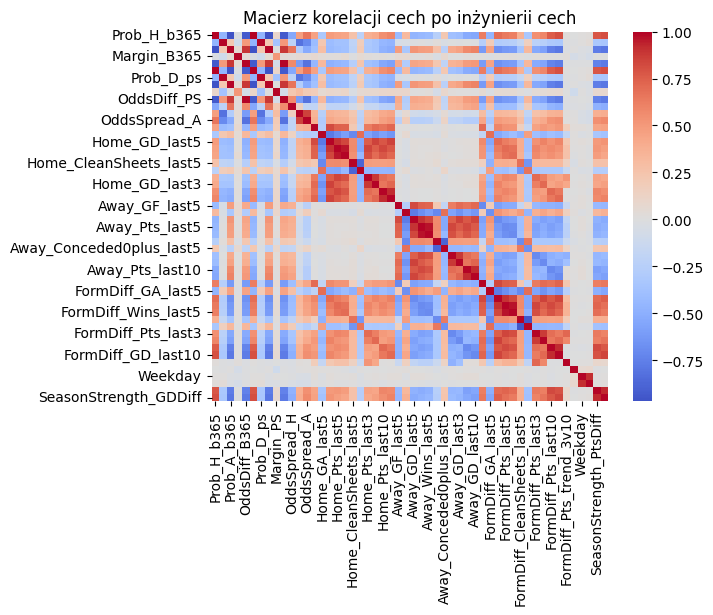

In [99]:
print("Liczba kolumn po FE:", len(df.columns))
print(sorted(df.columns))


corr = df[fe_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Macierz korelacji cech po inżynierii cech")
plt.show()


Dane są kompletne i poprawnie przetworzone.
Braki występują wyłącznie w cechach historycznych i wynikają z logicznego braku danych na początku sezonu.
Nie wymagają interwencji — można je zostawić lub wypełnić zerami przed modelowaniem.


In [100]:
df.to_csv(OUT_PATH, index=False)
OUT_PATH, df.shape


(WindowsPath('../data/processed/epl_features.csv'), (3420, 100))